# COMPAS Racial Bias Analysis

## Import Packages

In [1]:
import numpy as np
import matplotlib as matplt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn import (
    linear_model, metrics, pipeline, preprocessing, model_selection
)
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

## Prepare Data

In [2]:
raw_data = pd.read_csv("./data/compas-scores-two-years.csv")
print(raw_data.shape)
raw_data.head()

(7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### Data Description
* age: Age of the defendant. It is numeric.
* age_cat: Category of Age. It can be < 25, 25-45, >45.
* sex: Sex of the defendant. It is either 'Male' or 'Female'
* race: Race of the defendant. It can be 'African-American', 'Caucasian', 'Hispanic', 'Asian', or 'Other'.
* c_charge_degree: Degree of the crime. It is either M (Misdemeanor), F (Felony), or O (not causing jail time).
* priors_count: Count of prior crimes committed by the defendant. It is numeric.
* days_b_screening_arrest: Days between the arrest and COMPAS screening.
* decile_score: The COMPAS score predicted by the system. It is between 0-10.
* score_text: Category of decile score. It can be Low (1-4), Medium (5-7), and High (8-10).
* is_recid: A variable to indicate if recidivism was done by the defendant. It can be 0, 1, -1.
* two_year_recid: A variable to indicate if recidivism was done by the defendant within two years.
* c_jail_in: Time when the defendant was jailed.
* c_jail_out: Time when the defendant was released from the jail.

In [3]:
race, age, criminal history (priors_count), charge degree, gender

SyntaxError: invalid syntax (3191181717.py, line 1)

In [147]:
# raw_data.isna().sum()

### Data Cleaning
However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [181]:
df = raw_data.loc[
    (raw_data['days_b_screening_arrest'] <= 30) &
    (raw_data['days_b_screening_arrest'] >= -30) &
    (raw_data['is_recid'] != -1) &
    (raw_data['c_charge_degree'] != "O") &
    (raw_data['score_text'] != "N/A")
]
len(df)

6172

## COMPAS Score and Recidivism


We visualize the data to see how scores and race correlate to each other

### Exploratory Analysis

#### Score and Race

In [182]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [189]:
# Race by Score Text
pd.crosstab(df['score_text'],df['race'])

race,African-American,Caucasian,Hispanic
score_text,,,
High,845,223,47
Low,1346,1407,368
Medium,984,473,94


<AxesSubplot:title={'center':'Score Text by Race'}, xlabel='Race', ylabel='Score Text'>

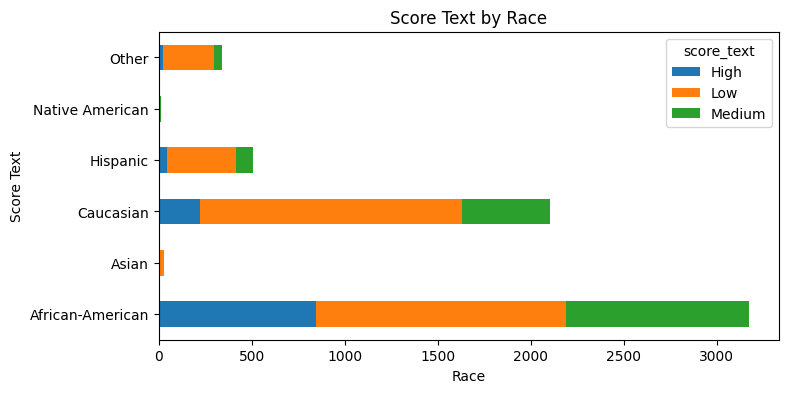

In [183]:
score_text_by_race = df.groupby(['race','score_text'], sort = True)['id'].size()
score_text_by_race.unstack().plot(
    kind = "barh", 
    title = "Score Text by Race",
    ylabel = "Score Text",
    xlabel = "Race",
    figsize = (8,4),
    stacked = True
)

African American group has the highest number of High Scores individuals. However, they are also the biggest group, so we need to consider the proportions of score text in each Race group. Since we have significantly more samples for African-American, Caucasian and Hispanic, we will focus on these three groups only.

In [184]:
df = df.loc[df['race'].isin(["African-American","Caucasian","Hispanic"])]

In [185]:
#calculate the total and proportions of score texts in each race group
score_text_by_race_prop= df.groupby(['race', 'score_text']).agg({'score_text': 'count'})
score_text_by_race_prop['prop'] = score_text_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))
score_text_by_race_prop

score_text       prop
race             score_text                       
African-American High               845  26.614173
                 Low               1346  42.393701
                 Medium             984  30.992126
Caucasian        High               223  10.603899
                 Low               1407  66.904422
                 Medium             473  22.491679
Hispanic         High                47   9.233792
                 Low                368  72.298625
                 Medium              94  18.467583

In [188]:
df.groupby('race')['decile_score'].mean()

race
African-American    5.276850
Caucasian           3.635283
Hispanic            3.383104
Name: decile_score, dtype: float64

26,6% of African-American defendants are classified with High Scores compared to 10.6% of Caucasian group

#### Distribution of decile scores

Text(0, 0.5, 'Count')

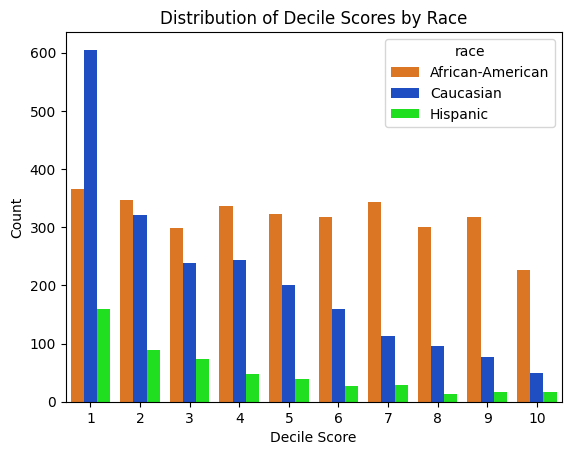

In [191]:
sns.countplot(
    data = df,
    x = 'decile_score',
    hue = 'race',
    palette = ["#F97306","#0343DF","#00FF00"]
)
plt.title('Distribution of Decile Scores by Race')
plt.xlabel('Decile Score')
plt.ylabel('Count')

There is a clear downtrend in Decile Score for Caucasian and Hispanic; however, no downtrend for African-American.

### COMPAS Score Prediction

#### Linear Regression Model
features:
* race
* age group (age_cat)
* criminal history (priors_count)
* Felony or Misdemeanor charge (charge degree) 
* sex

In [193]:
features = pd.concat(
    [pd.get_dummies(df.age_cat, prefix='age'),
     pd.get_dummies(df.sex, prefix='sex'),
     pd.get_dummies(df.c_charge_degree, prefix='degree'), # felony or misdemeanor charge ('f' or 'm')
     df.priors_count],
    axis=1)

# drop one less dummy variable
features.drop(['age_25 - 45', 'sex_Female', 'degree_M'], axis=1, inplace=True)

# predict the Decile Score
target = df.decile_score

### Lasso

In [196]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.25, random_state = 3)

In [211]:
alphas = 10**np.linspace(10,-2,1000)*0.5

In [218]:
# Lasso Model
# find the best alpha
lasso_cv = linear_model.LassoCV(alphas = alphas, cv = 10, max_iter = 100000).fit(X_train,y_train)
lasso_cv.alpha_

0.005

In [219]:
lasso_model = Lasso().set_params(alpha = lasso_cv.alpha_).fit(X_train,y_train)

y_pred= lasso_model.predict(X_test)

np.sqrt(metrics.mean_squared_error(y_test,y_pred))

2.259341551719152

In [216]:
lasso_cv_model = linear_model.RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True).fit(X_train, y_train)
lasso_cv_model.alpha_

0.005

### Ridge

In [224]:
ridge_model = linear_model.Ridge(alpha = lasso_cv_model.alpha_, normalize = True).fit(X_train, y_train)
metrics.mean_squared_error(y_test, ridge_model.predict(X_test))

5.100613454127368